In [1]:
#load packages
import pandas as pd 
import numpy as np
import scipy.stats as st
import xlsxwriter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
#load data and convert dates to datetime
fw = pd.read_csv("../Datasets/FW/FW_tail_numbers(cleaned).csv", encoding='latin-1', parse_dates=['dates'])

In [3]:
#inspect data
fw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13031 entries, 0 to 13030
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tail_number  13031 non-null  object        
 1   dates        13031 non-null  datetime64[ns]
 2   aircraft     13005 non-null  object        
 3   origin       13030 non-null  object        
 4   destination  13031 non-null  object        
 5   departure    13031 non-null  object        
 6   arrival      12788 non-null  object        
 7   duration     12783 non-null  object        
 8   NAME         13031 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 916.4+ KB


In [4]:
#glimpse to data 
fw.head()

,tail_number,dates,aircraft,origin,destination,departure,arrival,duration,NAME
0,N7025P,2020-12-24,NaN,"Near Red Bluff, CA","Near Emigrant Gap, CA",09:25AM PST,10:02AM PST,0:36,A PRECIOUS LIFE FLIGHT LLC ...
1,N7025P,2020-11-27,NaN,Redding Muni,"Near Chico, CA",11:26AM PST,11:42AM PST,0:16,A PRECIOUS LIFE FLIGHT LLC ...
2,N269GJ,2020-12-18,LJ60,Aurora Muni,Fort Lauderdale Exec,08:53AM CST,12:20PM EST,2:26,AEROCARE MEDICAL TRANSPORT SYSTEM INC ...
3,N888CP,2021-02-11,LJ31,Aurora Muni,Aurora Muni,10:32AM CST,11:25AM CST,0:53,AEROCARE MEDICAL TRANSPORT SYSTEMS INC ...
4,N888CP,2021-01-24,LJ31,Akron-Canton Rgnl,Aurora Muni,04:41PM EST,04:58PM CST,1:17,AEROCARE MEDICAL TRANSPORT SYSTEMS INC ...


In [5]:
#chech for null values
fw.isna().sum()

tail_number      0
dates            0
aircraft        26
origin           1
destination      0
departure        0
arrival        243
duration       248
NAME             0
dtype: int64

In [6]:
#the null duration indicates that the flight was canceled or diverted. So, let's remove it 
fw = fw.dropna(subset=['duration'])

In [7]:
# drop flight that was just scheduled 
fw = fw.query("duration != 'Scheduled'")

In [8]:
# convert duration to minutes and add a new column 
fw['duration_minutes'] = pd.to_datetime(fw.duration, format="%H:%M").dt.hour * 60 + pd.to_datetime(fw.duration, format="%H:%M").dt.minute

# convert duration to the H:M format
fw.duration = pd.to_datetime(fw.duration, format="%H:%M").dt.time

#rearrange data for the convenience
fw = fw.iloc[:,:8].join([fw.iloc[:,-1], fw.loc[:,'NAME']])

In [9]:
!!!# let's consider flights which more or equal 5 minutes. We don't think that flight that less than 5 minutes has any sense.
fw = fw.query("duration_minutes >= 5")

In [10]:
# total number of flights by each service and its tail number 
total_flights = pd.DataFrame(fw.groupby("NAME").tail_number.value_counts()).rename({'tail_number':'Number of Flights'}, axis=1)

# Average Flights per Day
avg_total_flights = pd.Series(fw.groupby("NAME").tail_number.value_counts().sort_index() / fw.groupby(['NAME','tail_number']).dates.nunique(), name='Average Flights per Day')

In [11]:
stats = fw.groupby(["NAME", 'tail_number']).duration_minutes.agg(['sum','mean', 'median', 'max', 'min'])\
          .rename({'sum':'Total Duration(min)', 'mean':'Average Duration(min)', 'median':'Median Duration(min)', 'max':'MAX Duration(min)', 'min':'MIN Duration(min)'}, axis=1)

In [12]:
#total summary statistics 
total_stats = total_flights.join([avg_total_flights, stats])
total_stats.head()

,,Number of Flights,Average Flights per Day,Total Duration(min),Average Duration(min),Median Duration(min),MAX Duration(min),MIN Duration(min)
NAME,tail_number,,,,,,,
A PRECIOUS LIFE FLIGHT LLC,N7025P,2,1.000000,52,26.000000,26.0,36,16
AEROCARE MEDICAL TRANSPORT SYSTEM INC,N269GJ,1,1.000000,146,146.000000,146.0,146,146
AEROCARE MEDICAL TRANSPORT SYSTEMS INC,N888CP,110,3.055556,7525,68.409091,45.0,224,9
AEROMED TRANSPORT CO LLC,N80YD,43,1.592593,2489,57.883721,50.0,263,5
AIR AMBULANCE BY AIR TREK INC,N644AT,96,2.526316,8247,85.906250,86.5,190,9


In [13]:
# Origins (where does the flight start each time)
Origins = pd.DataFrame(fw.groupby(['NAME', 'tail_number']).origin.value_counts()).rename({'origin':'Number of Flights'}, axis=1)
Origins.head()

Number of Flights
NAME                                               tail_number origin                                
A PRECIOUS LIFE FLIGHT LLC                         N7025P      Near Red Bluff, CA                   1
                                                               Redding Muni                         1
AEROCARE MEDICAL TRANSPORT SYSTEM INC              N269GJ      Aurora Muni                          1
AEROCARE MEDICAL TRANSPORT SYSTEMS INC             N888CP      Aurora Muni                         34
                                                               Chicago Midway Intl                 23

In [14]:
# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('..//Datasets/FW/FW_stats.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# total_stats.to_excel(writer, sheet_name='stats')
# Origins.to_excel(writer, sheet_name='origin')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

## Time Series Analysis
---
Data cleaning and transformation

In [15]:
# split time zone and assign to new variable for arrival
fw['arr_time_zone'] = fw.arrival.str.split(" ", n = 1, expand = True)[1]

# remove time zome from arrival
fw.arrival = fw.arrival.str.split(" ", n = 1, expand = True)[0]

# rearrange data for the convenience 
fw = fw.iloc[:,:7].join([fw.iloc[:,-1], fw.iloc[:,7:10]])

In [16]:
# split time zone and assign to new variable for departure
fw['dep_time_zone'] = fw.departure.str.split(" ", n = 1, expand = True)[1]

# remove time zome from departure
fw.departure = fw.departure.str.split(" ", n = 1, expand = True)[0]

# rearrange data for the convenience 
fw = fw.iloc[:,:6].join([fw.iloc[:,-1], fw.iloc[:,6:11]])

In [17]:
# convert departure time to the 24-format 
fw.departure = pd.to_datetime(fw.departure).dt.strftime('%H:%M')

# convert arrival time to the 24-format 
fw.arrival = pd.to_datetime(fw.arrival, errors='coerce').dt.strftime('%H:%M')

In [18]:
# drop all unconverted records
fw = fw.dropna(subset=['arrival'])

In [19]:
#fw.to_csv(r'..//Datasets/FW_tail_numbers(converted to min and 24-hour format).csv', index=False)

In [20]:
# Let's figure out the date range of our dataset with which we will deal
print("From", fw.dates.dt.date.min(), "to", fw.dates.dt.date.max())

From 2020-10-30 to 2021-02-13


### Tables and graphs

In [21]:
# total number of flight by day
fw_daily_flights = pd.DataFrame(fw.dates.value_counts()).sort_index()
fw_daily_flights.head()

,dates
2020-10-30,18
2020-10-31,75
2020-11-01,100
2020-11-02,82
2020-11-03,94


As we don't have access to the data for the entire October and February, we have to exclude the first and the last days of these months in our date range. 
Otherwise, it may give wrong outcomes.

In [22]:
# Excluse the first and last days of our data range
fw_daily_flights = fw_daily_flights.loc['2020-10-31':'2021-2-12'].rename({'dates':'Number of flights'}, axis=1)

# Add a moving Average for week window to see trend
fw_daily_flights['Moving average for week window'] = fw_daily_flights['Number of flights'].rolling(window='7D').mean()

# Add a moving Average for 30 days window to see trend
fw_daily_flights['Moving average for 30 days window'] = fw_daily_flights['Number of flights'].rolling(window='30D').mean()

In [23]:
# add Covid19 cases to observe correlation. Source: https://covidtracking.com/data/download
covid19 = pd.read_csv('..//Datasets/covid-19/national-history.csv', parse_dates=['date'], index_col='date')
covid19 = pd.DataFrame(covid19.positiveIncrease.loc['2021-2-12':'2020-10-31']).rename({'positiveIncrease':'Number of cases'}, axis=1)

# Add a moving Average for week window to see trend
covid19['Moving average for week window'] = covid19['Number of cases'].rolling(window='7D').mean()

# Add a moving Average for 30 days window to see trend
covid19['Moving average for 30 days window'] = covid19['Number of cases'].rolling(window='30D').mean()

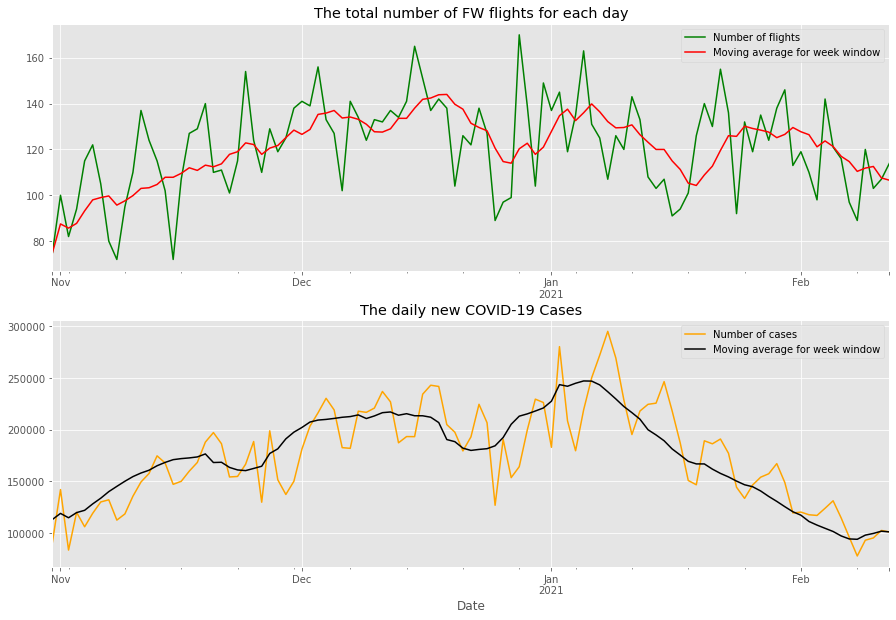

In [24]:
# Let's visualize the number of FW flight for each day with weekly moving average 

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
fw_daily_flights.iloc[:,:-1].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The total number of FW flights for each day")
covid19.iloc[:,:-1].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
#plt.savefig('FW_weekly_covid.jpeg')
plt.show()

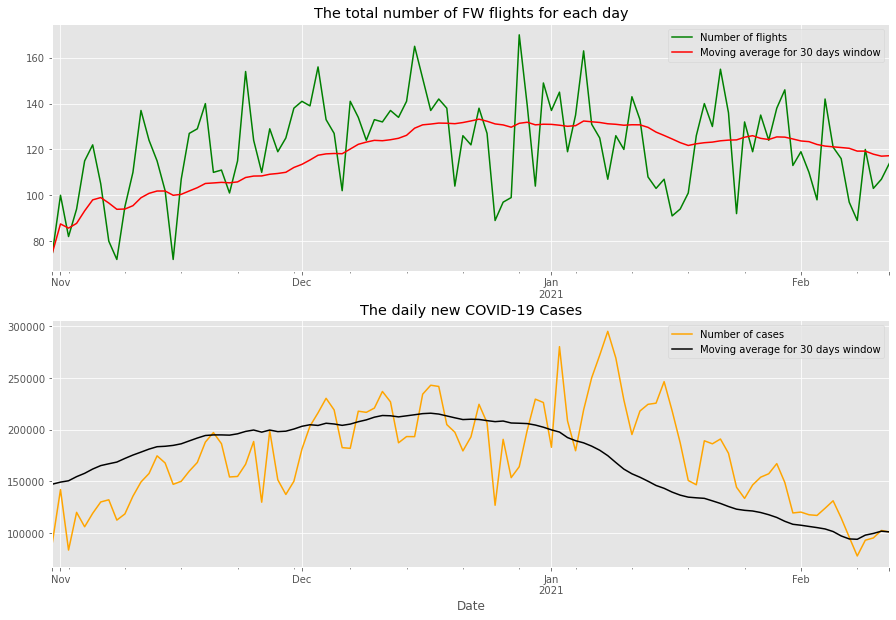

In [25]:
# Let's visualize the number of FW flight for each day with 30-days moving average 

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
fw_daily_flights.iloc[:,[0,2]].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The total number of FW flights for each day")
covid19.iloc[:,[0,2]].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
#plt.savefig('FW_monthly_covid.jpeg')
plt.show()

In [26]:
# create new variable of flight duration for each day from 2020-10-31 to 2021-2-12 and calculate average duration for each day
fw_avg_duration = pd.DataFrame(fw.groupby('dates').duration_minutes.mean()).rename({'duration_minutes':'Average duration'}, axis=1)\
                    .loc['2020-10-31':'2021-2-12']
# remove index name
fw_avg_duration.index.name = None

In [27]:
# Add a moving Average for week window to see trend
fw_avg_duration['Moving average for week window'] = fw_avg_duration['Average duration'].rolling(window='7D').mean()

# Add a moving Average for 30 days window to see trend
fw_avg_duration['Moving average for 30 days window'] = fw_avg_duration['Average duration'].rolling(window='30D').mean()

fw_avg_duration.head()

,Average duration,Moving average for week window,Moving average for 30 days window
2020-10-31,52.013333,52.013333,52.013333
2020-11-01,60.780000,56.396667,56.396667
2020-11-02,54.512195,55.768509,55.768509
2020-11-03,59.595745,56.725318,56.725318
2020-11-04,62.895652,57.959385,57.959385


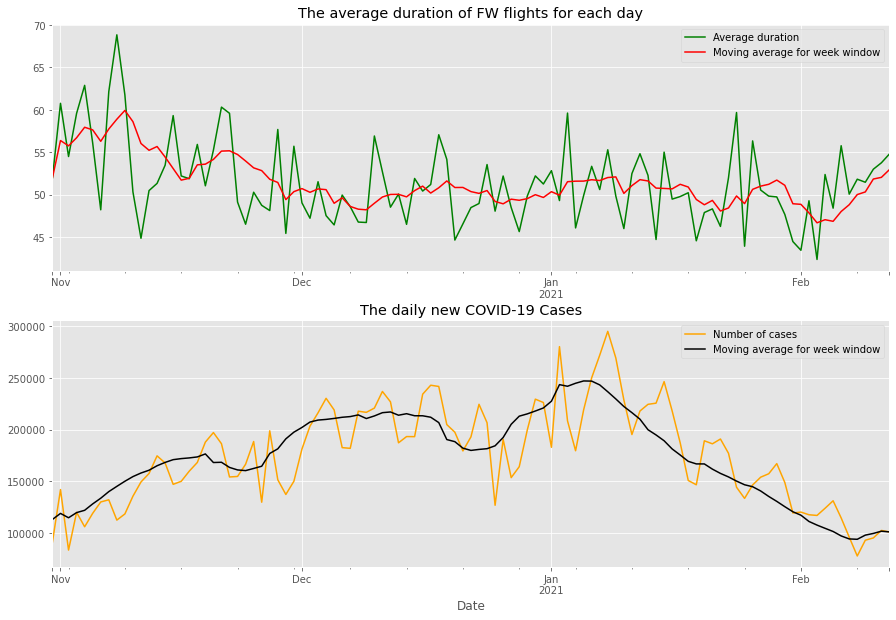

In [28]:
# Let's visualize the average duration of RW flight for each day

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
fw_avg_duration.iloc[:,:-1].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The average duration of FW flights for each day")
covid19.iloc[:,:-1].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
#plt.savefig('avg_FW_weekly_covid.jpeg')
plt.show()

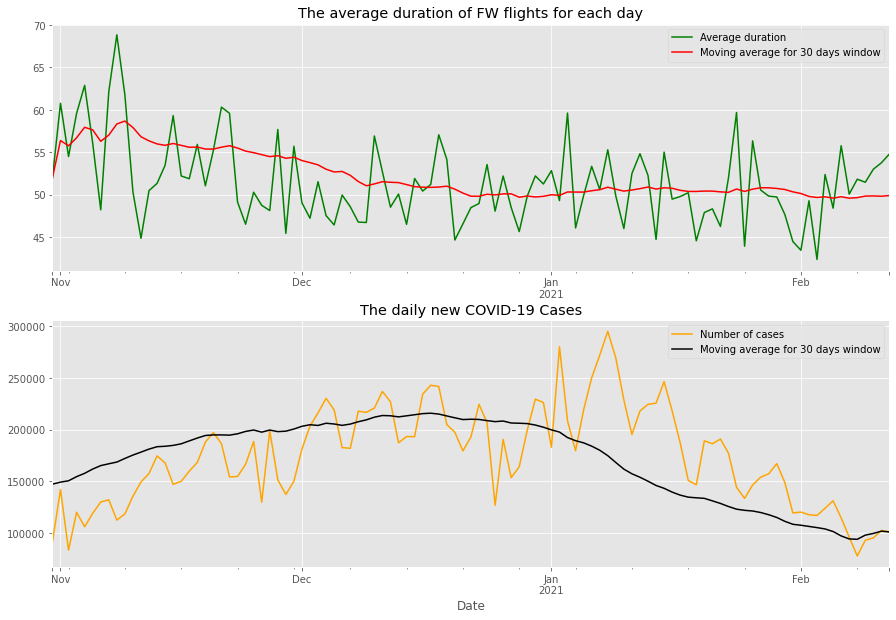

In [29]:
# Let's visualize the average duration of RW flight for each day with monthly moving average

fig, ax = plt.subplots(2)
fig.set_size_inches(15, 10)
fw_avg_duration.iloc[:,[0,2]].plot(ax=ax[0],color=['green', 'red'])
ax[0].set_title("The average duration of FW flights for each day")
covid19.iloc[:,[0,2]].plot(ax=ax[1], color=['orange', 'black'])
ax[1].set_title("The daily new COVID-19 Cases")
plt.xlabel("Date")
#plt.savefig('avg_FW_monthly_covid.jpeg')
plt.show()

In [30]:
# hourly shift scheduling
fw_hour_shift  = fw[['dates', 'departure', 'arrival']].set_index('dates')

In [31]:
# conver and extract hour for each date 
fw_hour_shift.departure = pd.to_datetime(fw_hour_shift.departure).dt.hour
fw_hour_shift.arrival = pd.to_datetime(fw_hour_shift.arrival).dt.hour

In [32]:
fw_hour_shift.head()

,departure,arrival
dates,,
2020-12-24,9,10
2020-11-27,11,11
2020-12-18,8,12
2021-02-11,10,11
2021-01-24,16,16


Text(0.5, 1.0, 'Histogram of FW Departure Hours')

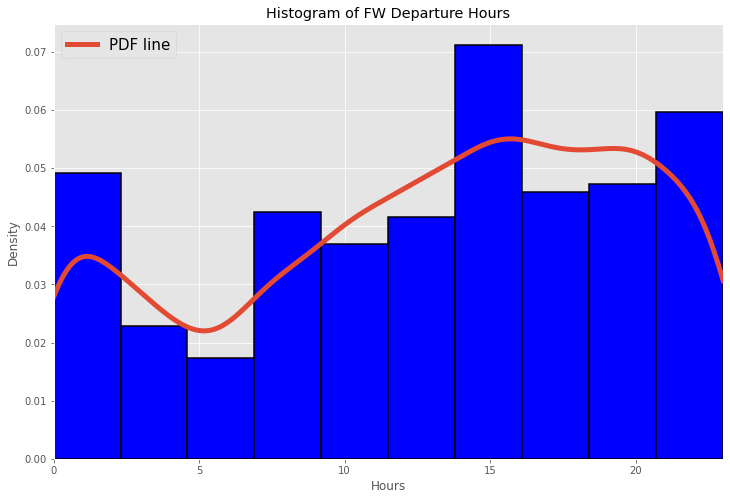

In [33]:
# plot the histogram of departure hours 
plt.figure(figsize=(12,8))
plt.hist(fw_hour_shift.departure, density=True, color='blue', edgecolor='black', linewidth=1.5)
plt.xlim(left = 0, right=23)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(fw_hour_shift.departure)
plt.plot(kde_xs, kde.pdf(kde_xs), linewidth=5, label="PDF line")
plt.legend(loc="upper left", prop={'size': 15})
plt.xlabel('Hours')
plt.ylabel('Density')
plt.title('Histogram of FW Departure Hours')
#plt.savefig('fw_dep_hour_hist.jpeg')

Text(0.5, 1.0, 'Histogram of FW Arrival Hours')

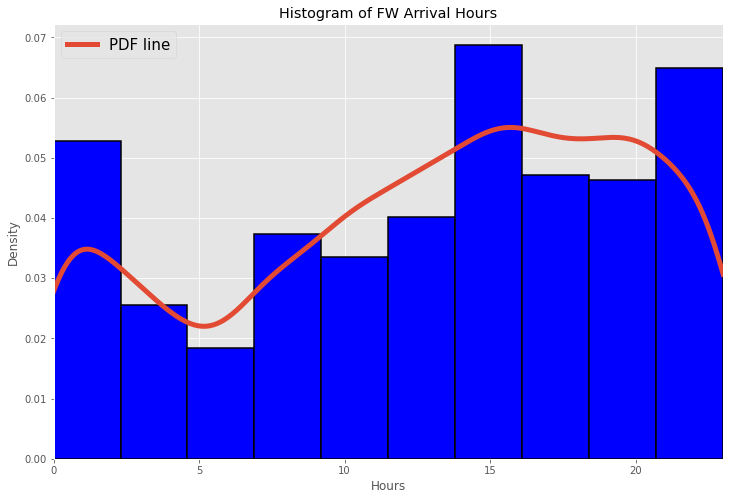

In [34]:
# plot the histogram of arrival hours 
plt.figure(figsize=(12,8))
plt.hist(fw_hour_shift.arrival, density=True, color='blue', edgecolor='black', linewidth=1.5)
plt.xlim(left = 0, right=23)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(fw_hour_shift.departure)
plt.plot(kde_xs, kde.pdf(kde_xs), linewidth=5, label="PDF line")
plt.legend(loc="upper left", prop={'size': 15})
plt.xlabel('Hours')
plt.ylabel('Density')
plt.title('Histogram of FW Arrival Hours')
#plt.savefig('fw_arr_hour_hist.jpeg')